In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

np.random.seed(5)

In [2]:
#Loading the data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Shapes

print('train shape:',train.shape)
print('test shape',test.shape)

train shape: (42000, 785)
test shape (28000, 784)


In [4]:
train_y = train['label'].astype('float32')
train_x = train.drop(['label'],axis=1).astype('int32')
test_x = test.astype('float32')

print('train_x shape: ',train_x.shape)
print('train_y shape: ',train_y.shape)
print('test_x shape: ',test_x.shape)

train_x shape:  (42000, 784)
train_y shape:  (42000,)
test_x shape:  (28000, 784)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


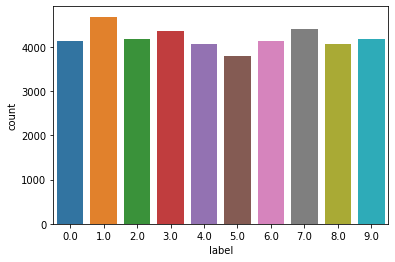

1.0    4684
7.0    4401
3.0    4351
9.0    4188
2.0    4177
6.0    4137
0.0    4132
4.0    4072
8.0    4063
5.0    3795
Name: label, dtype: int64

In [5]:
sns.countplot(train_y)
plt.show()
train_y.value_counts()

In [6]:
train_x.shape

(42000, 784)

In [7]:
#Normalization and Reshape

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train_x = train_x.values.reshape(-1,28,28,1)
# Normalize the data
train_x = train_x / 255.0
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
test_x = test_x.values.reshape(-1,28,28,1)
# Normalize the data
test_x = test_x / 255.0

print('train_x shape: ',train_x.shape)
print('test_x shape: ',test_x.shape)

train_x shape:  (42000, 28, 28, 1)
test_x shape:  (28000, 28, 28, 1)


In [8]:
#One Hot Encoding

train_y = tf.keras.utils.to_categorical(train_y,10)
train_y.shape

(42000, 10)

In [9]:
train['label'].head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [10]:
train_y[0:5,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
#split the train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_x,train_y,test_size=0.1,random_state=5)

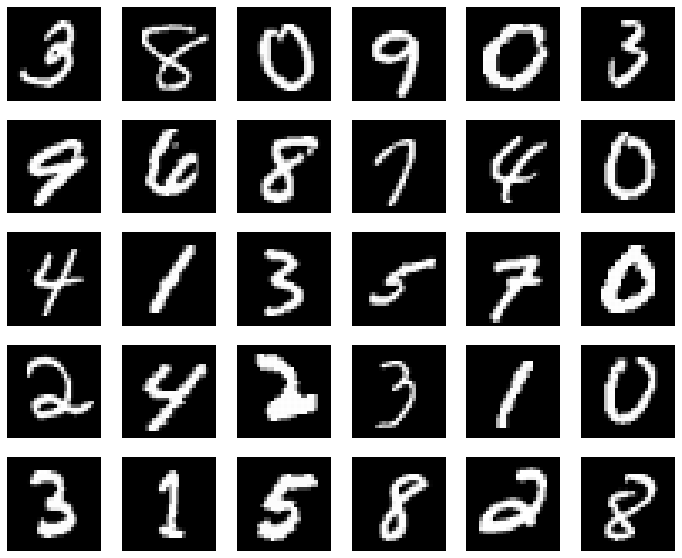

In [12]:
#Visualization

rows = 5
cols = 6

f = plt.figure(figsize=(2*cols,2*rows)) #defining a figure

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')
    plt.axis('off')

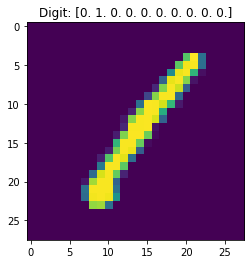

In [13]:
#visualization of the first number

plt.imshow(train_x[0].reshape(28,28))
plt.title(f'Digit: {train_y[0]}')
plt.show()

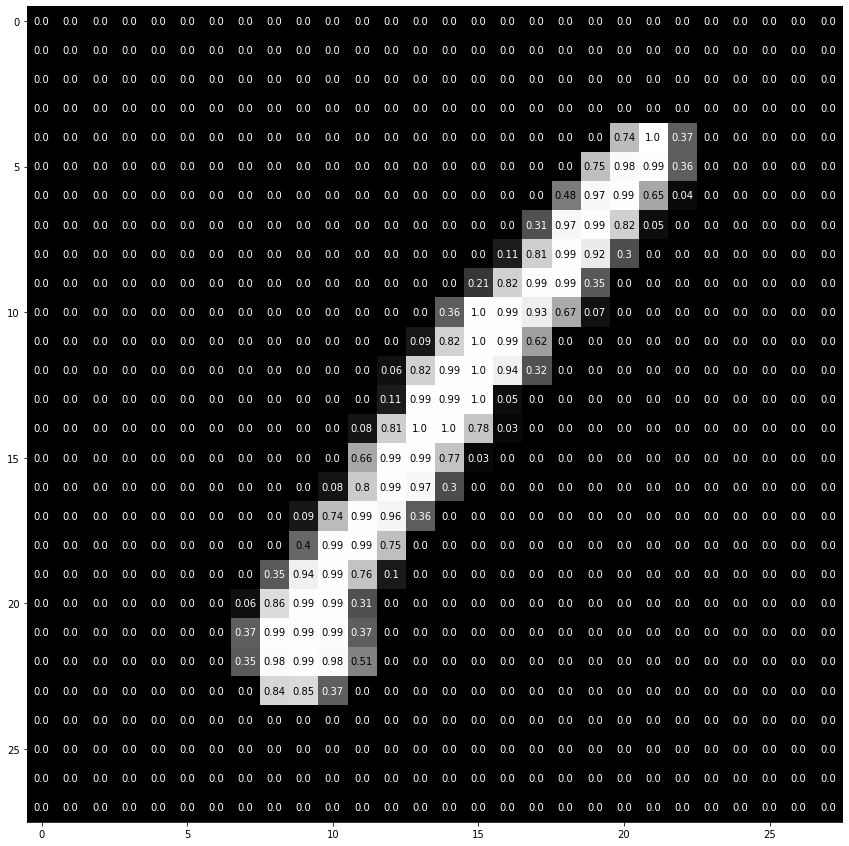

In [14]:
#Detail Visualization of first number

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
            horizontalalignment = 'center',
            verticalalignment = 'center',
            color = 'white' if img[x][y]<thresh else 'black')

fig= plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
visualize_input(train_x[0].reshape(28,28),ax)

In [15]:
#Defining the model

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

2022-02-15 21:38:54.012484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
#Define the optimizer

optimizer = RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [17]:
#Compile the model

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
#Set a learning rate annealer

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [19]:
epochs=15
batch_size=86

In [20]:
#Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,zoom_range=0.1,width_shift_range=0.1,
                             height_shift_range=0.1)

datagen.fit(X_train)

In [21]:
#Fit the model

final = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),epochs=epochs,
                   validation_data=(X_val,y_val),
                   verbose=2,
                   steps_per_epoch=X_train.shape[0]//batch_size,
                   callbacks=[learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-02-15 21:38:55.014858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
439/439 - 52s - loss: 0.4857 - accuracy: 0.8373 - val_loss: 0.0723 - val_accuracy: 0.9764
Epoch 2/15
439/439 - 50s - loss: 0.1214 - accuracy: 0.9651 - val_loss: 0.0486 - val_accuracy: 0.9869
Epoch 3/15
439/439 - 51s - loss: 0.0893 - accuracy: 0.9743 - val_loss: 0.0535 - val_accuracy: 0.9848
Epoch 4/15
439/439 - 51s - loss: 0.0714 - accuracy: 0.9795 - val_loss: 0.0330 - val_accuracy: 0.9919
Epoch 5/15
439/439 - 50s - loss: 0.0648 - accuracy: 0.9819 - val_loss: 0.0395 - val_accuracy: 0.9898
Epoch 6/15
439/439 - 51s - loss: 0.0578 - accuracy: 0.9827 - val_loss: 0.0318 - val_accuracy: 0.9905
Epoch 7/15
439/439 - 50s - loss: 0.0530 - accuracy: 0.9850 - val_loss: 0.0351 - val_accuracy: 0.9910
Epoch 8/15
439/439 - 53s - loss: 0.0517 - accuracy: 0.9854 - val_loss: 0.0320 - val_accuracy: 0.9902
Epoch 9/15
439/439 - 51s - loss: 0.0447 - accuracy: 0.9870 - val_loss: 0.0403 - val_accuracy: 0.9895
Epoch 10/15
439/439 - 50s - loss: 0.0474 - accuracy: 0.9866 - val_loss: 0.0307 - val_accura

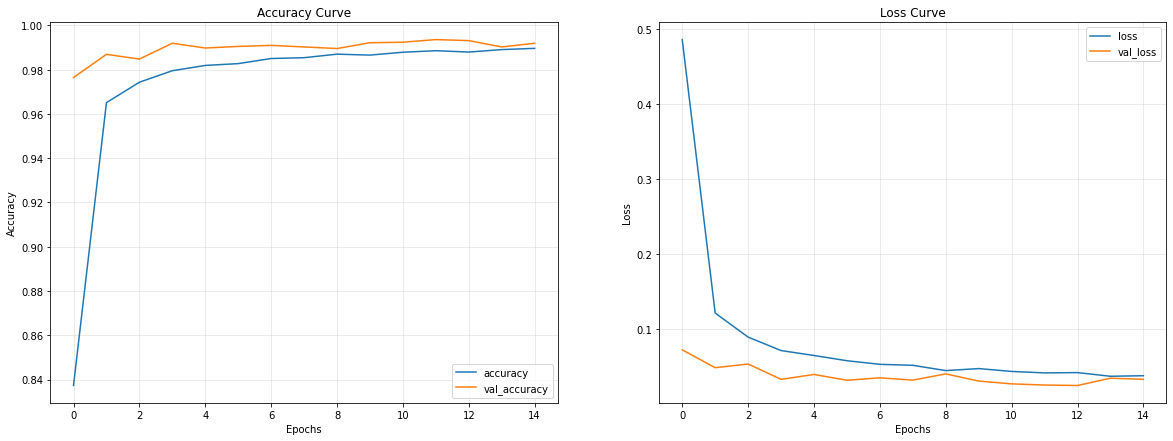

In [22]:
# Plot the loss and accuracy curves for training and validation 

f = plt.figure(figsize=(20,7))
f.add_subplot(121)
plt.plot(final.epoch,final.history['accuracy'],label='accuracy')
plt.plot(final.epoch,final.history['val_accuracy'],label='val_accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend()

f.add_subplot(122)
plt.plot(final.epoch,final.history['loss'],label='loss')
plt.plot(final.epoch,final.history['val_loss'],label='val_loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()

plt.show()

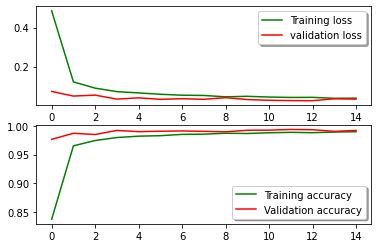

In [23]:
#Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)
ax[0].plot(final.history['loss'], color='g', label="Training loss")
ax[0].plot(final.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(final.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(final.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
#Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

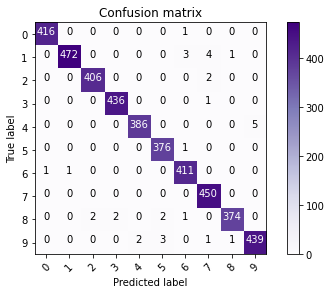

In [25]:
#Predict the values from the validation dataset
y_pred = model.predict(X_val)
#Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
#Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
#Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
#Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


We can observe that our CNN performs very well on all digits with few errors considering the size of the validation set.

However, it seems that our CNN has some little troubles with the 4 digits,where they are misclassified as 9. Sometimes it is very difficult to catch the difference between 4 and 9 when curves are smooth.

**Investigating The Errors**

In [26]:
errors = (y_pred_classes - y_true !=0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

In [27]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

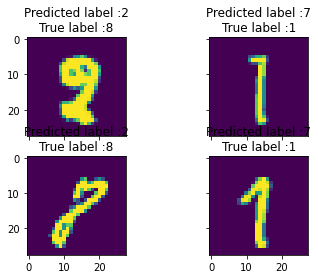

In [28]:
#Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

#Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

#Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

#Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

#Top 6 errors 
most_important_errors = sorted_dela_errors[-10:]

#Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

It seems inaccuracy error digits even looking with human eyes. We can consider that our model is very well even have these missclasses.

# **Prediction**

In [29]:
results = model.predict(test_x)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [30]:
#Submission

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
#submission
submission.to_csv("submission.csv",index=False)
print("Successfully Completed!")

Successfully Completed!
